# Using Finta for Trading Signals - ML Version

In this demo, we will be utilizing the [finta Python library](https://pypi.org/project/finta/) that will power a machine learning trading system.

In the previous demo, we built the dataset (X and y) for input into the model. We then `fit` the model and made predictions using the training dataset. In this demo, we'll use that fitted model to make predictions on the test dataset, and calculate total out-of-sample economic performance to the ML-based trading strategy.


## Starter Code (Done in the Previous Demo)

### Build `X` and `y` Datasets

In [21]:
# Import
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)
# Import the finta Python library and the TA module
from finta import TA
# ## Import the CSV file and create the Pandas DataFrame
# Read in CSV file in from the resources folder into a Pandas DataFrame
# Set the date as the DateTimeIndex
df = pd.read_csv(
    Path("../algotrader2/resources/aapl_15min_df.csv"),
    index_col = "timestamp", 
    parse_dates = True, 
    infer_datetime_format = True
)
# Use the pct_change function to generate the returns from "close"
df["actual_returns"] = df["close"].pct_change()
# Drop all NaN values from the DataFrame
df = df.dropna()
# Generate the Input Features, X
# Create a simple moving average (SMA) using a window size of 4. 
# Assign this to a column called `sma_fast`
short_window = 4
df['sma_fast'] = TA.SMA(df, 4)
# Create a simple moving average (SMA) using a window size of 100. 
# Assign this to a column called `sma_slow`
long_window = 100
df['sma_slow'] = df['close'].rolling(window=long_window).mean()
# Create additional technical indicators
df["ssma"] = TA.SSMA(df)
df["ema"] = TA.EMA(df, 50)
df["dema"] = TA.DEMA(df)
df["tema"] = TA.TEMA(df)
df["trima"] = TA.TRIMA(df)
# Drop the NaNs using dropna()
df = df.dropna()
# Assign a copy of the technical variable columns to a new DataFrame called `X` and lag it.
X = df[['sma_fast', 'sma_slow', 'ssma', 'ema', 'dema', 'tema', 'trima']].shift().dropna().copy()
# Initialize the new `Signal` column
df['signal'] = 0.0
# Generate signal to buy stock long
df.loc[(df['actual_returns'] >= 0), 'signal'] = 1
# Generate signal to sell stock short
df.loc[(df['actual_returns'] < 0), 'signal'] = -1
df.tail(3)
# Copy the new "signal" column to a new Series called `y`.
y = df['signal']
display(X.head(1))
display(y.head(2))

/var/folders/tl/pmdc2_wx3hx1zkjc2fzswyyc0000gn/T/ipykernel_43283/4036010973.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


,sma_fast,sma_slow,ssma,ema,dema,tema,trima
timestamp,,,,,,,
2023-01-04 18:15:00+00:00,127.60875,126.834219,127.174581,126.570881,127.686913,127.565041,126.465085


timestamp
2023-01-04 18:00:00+00:00   -1.0
2023-01-04 18:15:00+00:00    1.0
Name: signal, dtype: float64

## Starter Code (Done in the Previous Demo): 

### Split the Data into Training and Test Datasets

In [22]:
# Import the neccessary Date function
from pandas.tseries.offsets import DateOffset

# Use the following code to select the start of the training period: `training_begin = X.index.min()`
training_begin = X.index.min()
print(training_begin)

# Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
training_end = X.index.min() + DateOffset(months=6)
print(training_end)

# Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# Hint: Use `loc[training_begin:training_end]` for X_train and y_train
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# Hint: Use `loc[training_end:]` for X_test and y_test
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Use StandardScaler to scale the X_train and X_test data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

from imblearn.over_sampling import RandomOverSampler
# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

2023-01-04 18:15:00+00:00
2023-07-04 18:15:00+00:00


In [23]:
X_resampled

array([[-2.10783477, -2.1303081 , -2.13210088, ..., -2.10346979,
        -2.11111255, -2.17059431],
       [-2.12041573, -2.1325839 , -2.13150663, ..., -2.11067492,
        -2.12068942, -2.16758852],
       [-2.12827472, -2.13491777, -2.12988675, ..., -2.11252975,
        -2.12210638, -2.16437878],
       ...,
       [ 0.00449028,  0.03062276, -0.00329169, ...,  0.00674204,
         0.00585149, -0.01616863],
       [ 1.03224602,  1.04883789,  1.03381936, ...,  1.03114452,
         1.0294061 ,  1.02834938],
       [-0.56424893, -0.4864627 , -0.56826472, ..., -0.56587933,
        -0.56329114, -0.57060526]])

In [24]:
y_resampled

0       1.0
1       1.0
2      -1.0
3      -1.0
4      -1.0
       ... 
8087   -1.0
8088   -1.0
8089   -1.0
8090   -1.0
8091   -1.0
Name: signal, Length: 8092, dtype: float64

### Train and Generate Trade Predictions

In [25]:
# Create the classifier model.
from sklearn.svm import SVC
model = SVC()
 
# Fit the model to the data using X_train_scaled and y_train
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_resampled)

# Evaluate the model using a classification report
from sklearn.metrics import classification_report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.33      0.41      4046
         1.0       0.51      0.69      0.59      4046

    accuracy                           0.51      8092
   macro avg       0.51      0.51      0.50      8092
weighted avg       0.51      0.51      0.50      8092



## New Code: Backtest the Trading Algorithm

In this section, we will use the testing data to backtest the trading algorithm using the trained machine learning model. 

* Use the trained model to predict the trading signals for the testing data.
* Evaluate the model's ability to predict the trading signal for the testing data using a classification report
* Create a new empty predictions DataFrame using code provided below.
* Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`

In [26]:
X_test_scaled

array([[1.94378149, 2.00550742, 1.949753  , ..., 1.94298708, 1.94431799,
        1.95377069],
       [1.93440321, 2.00573882, 1.94527776, ..., 1.92911702, 1.92526112,
        1.95248217],
       [1.92580646, 2.00597016, 1.94150823, ..., 1.91992935, 1.91413669,
        1.9512689 ],
       ...,
       [1.36736303, 1.44366059, 1.37082103, ..., 1.36825614, 1.36453152,
        1.36148915],
       [1.3662689 , 1.44201622, 1.37063461, ..., 1.36684308, 1.36337237,
        1.36310467],
       [1.36486216, 1.4402937 , 1.36970454, ..., 1.36336347, 1.35941646,
        1.3647829 ]])

In [27]:
# Evaluate the model's ability to predict the trading signal for the testing data using a classification report

testing_signal_predictions = model.predict(X_test_scaled)

training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.19      0.27      4076
         1.0       0.53      0.81      0.64      4517

    accuracy                           0.52      8593
   macro avg       0.50      0.50      0.46      8593
weighted avg       0.51      0.52      0.47      8593



In [28]:
testing_signal_predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [29]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_returns'] = testing_signal_predictions
predictions_df['predicted_returns'].value_counts()

predicted_returns
 1.0    6973
-1.0    1620
Name: count, dtype: int64

In [30]:
# Add in actual returns and calculate trading returns
predictions_df['actual_returns'] = df['actual_returns']
predictions_df['trading_algorithm_returns'] = predictions_df['actual_returns'] * predictions_df['predicted_returns']
predictions_df

,predicted_returns,actual_returns,trading_algorithm_returns
timestamp,,,
2023-07-05 08:00:00+00:00,1.0,-0.003378,-0.003378
2023-07-05 08:15:00+00:00,1.0,0.000156,0.000156
2023-07-05 08:30:00+00:00,1.0,-0.000417,-0.000417
2023-07-05 08:45:00+00:00,1.0,-0.001304,-0.001304
2023-07-05 09:00:00+00:00,1.0,-0.001567,-0.001567
...,...,...,...
2024-01-16 23:45:00+00:00,1.0,0.000328,0.000328
2024-01-17 00:00:00+00:00,1.0,0.000000,0.000000
2024-01-17 00:15:00+00:00,1.0,-0.000218,-0.000218


<Axes: xlabel='timestamp'>

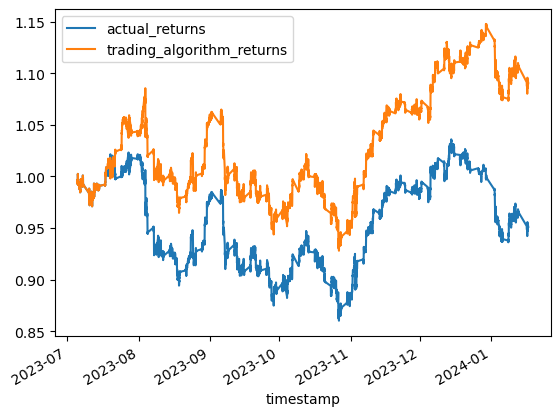

In [31]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot()